based on https://pennylane.ai/qml/demos/tutorial_qcbm#liu

Let $\{x'\}$ be a dataset of samples drawn, indipendently, from the same unknown probability distribution $\pi(x')$. We want to approximate it with a QCBM, treated as an implicit generative model, returning a parametrized quantum state $\ket{\psi(\theta)}$, that we sample to get our probability distribution $p(\theta)$. To train the circuit we need a loss function comparing the two functions, one possible choice is Maximum Mean Discrepancy. In general, MMD is defined by the idea of representing distances between distributions as distances between mean embeddings of features. The MMD is zero if and only if the two distributions are the same.
$$ L(\theta) = \left\| \sum_x p_\theta(x) \phi(x) - \sum_x \pi(x) \phi(x) \right\|^2 $$



<p align="center">
  <img src="./img/img_1.1.png" alt="image 1.1" />
</p>


For computational and analytical convenience we can reconduct the procedure to the calculation of a kernel function:
$$ K(x, y) = \frac{1}{c} \sum_{i=1} \exp\left(\frac{|x - y|^2}{2 \sigma_i^2}\right) $$

where we are avaraging over multiple possible gaussians. We can rewrite the expression for L in terms of K:

$$ L = \mathbb{E}_{x\sim p_\theta, y \sim p_\theta} \left[ K(x, y) \right] - 2 \mathbb{E}_{x \sim p_\theta, y \sim \pi} \left[ K(x, y) \right] + \mathbb{E}_{x\sim \pi, y \sim \pi} \left[ K(x, y) \right] = $$
$$ =\sum_{x, y} p(x) p(y) K(x, y)-2 \sum_{x, y} p(x) \pi(y) K(x, y)+\sum_{x, y} \pi(x) \pi(y) K(x, y)= $$
$$ = \sum_{x, y} K(x, y)(p(x) p(y)-2 p(x) \pi(y)+\pi(x) \pi(y))= $$
$$ = \sum_{x, y} K(x, y)(p(x)-\pi(x))(p(y)-\pi(y)) $$



In [27]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)


class MMD:

    # Function init takes a list of sigma values and a "space vector", containing all possible states in the hilbert 
    # space: space = (1,...,2^#qubits-1). We will calculate all possible distances between states in the space vector, 
    # summing the kernel function for each sigma value, to get the kernel matrix K. The operation space[:, None] - space[None, :]
    # means the "difference" between a row and a column vector, returning a matrix with all possible differences between states.

    def __init__(self, SigmaVector, space):
        gammas = 1 / (2 * (SigmaVector**2))

        sq_dists = jnp.abs(space[:, None] - space[None, :]) ** 2 

        self.K = sum(jnp.exp(-gamma * sq_dists) for gamma in gammas) / len(SigmaVector)
        self.SigmaVector = SigmaVector

    # Function KExpVal calculates the expectation value of the K(x,y) kernel function, where x and y are drawn from px and py
    # distributions, respectively. Brief proof of the expectation value calculation for 2 states 0 and 1:
    # K = (k00,k01)
    #     (k10,k11)
    # px = (px0,px1)
    # py = (py0,py1)
    # KExpVal = px0*py0*k00 + px0*py1*k01 + px1*py0*k10 + px1*py1*k11 = sum(px_i*py_j*kij) for i,j summed over all states (0,1).
         
    def KExpVal(self, px, py):
        return px @ self.K @ py

    # Function __call__ (that is called as MMD() function) calculates the MMD between two distributions px and py, where px and py
    # are probability vectors (using relaboration proves above).

    def __call__(self, px, py):
        pxy = px - py
        return self.KExpVal(pxy, pxy)

Let's define the Quantum Circuit Born Machine as an object that takes in input a parametrized quantum circuit, a loss calculation method and a target distribution, returning the loss value:

<p align="center">
  <img src="./img/img_1.2.png" alt="image 1.1" />
</p>

In [ ]:
from functools import partial

class QCBM:

    def __init__(self, circ, mmd, py):
        self.circ = circ    # our parametric quantum circuit
        self.mmd = mmd      # our loss calculation method
        self.py = py        # target distribution π(x)

    @partial(jax.jit, static_argnums=0) # decorator to speed up the optimization process keeping 1st argument fixed
    def MMD_Loss(self, params):
        px = self.circ(params)
        return self.mmd(px, self.py), px


In [4]:
import numpy as np


def get_bars_and_stripes(n):
    bitstrings = [list(np.binary_repr(i, n))[::-1] for i in range(2**n)]
    bitstrings = np.array(bitstrings, dtype=int)

    stripes = bitstrings.copy()
    stripes = np.repeat(stripes, n, 0)
    stripes = stripes.reshape(2**n, n * n)

    bars = bitstrings.copy()
    bars = bars.reshape(2**n * n, 1)
    bars = np.repeat(bars, n, 1)
    bars = bars.reshape(2**n, n * n)
    return np.vstack((stripes[0 : stripes.shape[0] - 1], bars[1 : bars.shape[0]]))


n = 3
size = n**2
data = get_bars_and_stripes(n)
print(data.shape)


(14, 9)



Sample bitstring: 100100100


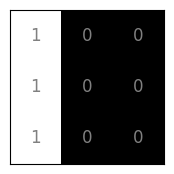

In [5]:
import matplotlib.pyplot as plt

sample = data[1].reshape(n, n)

plt.figure(figsize=(2, 2))
plt.imshow(sample, cmap="gray", vmin=0, vmax=1)
plt.grid(color="gray", linewidth=2)
plt.xticks([])
plt.yticks([])

for i in range(n):
    for j in range(n):
        text = plt.text(
            i,
            j,
            sample[j][i],
            ha="center",
            va="center",
            color="gray",
            fontsize=12,
        )

print(f"\nSample bitstring: {''.join(np.array(sample.flatten(), dtype='str'))}")


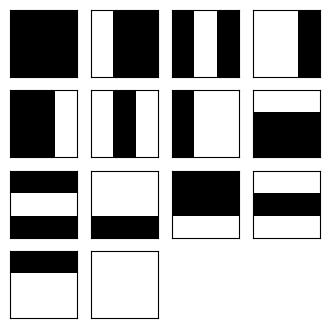

In [6]:
plt.figure(figsize=(4, 4))
j = 1
for i in data:
    plt.subplot(4, 4, j)
    j += 1
    plt.imshow(np.reshape(i, (n, n)), cmap="gray", vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])


In [7]:
bitstrings = []
nums = []
for d in data:
    bitstrings += ["".join(str(int(i)) for i in d)]
    nums += [int(bitstrings[-1], 2)]
print(nums)


[0, 292, 146, 438, 73, 365, 219, 448, 56, 504, 7, 455, 63, 511]


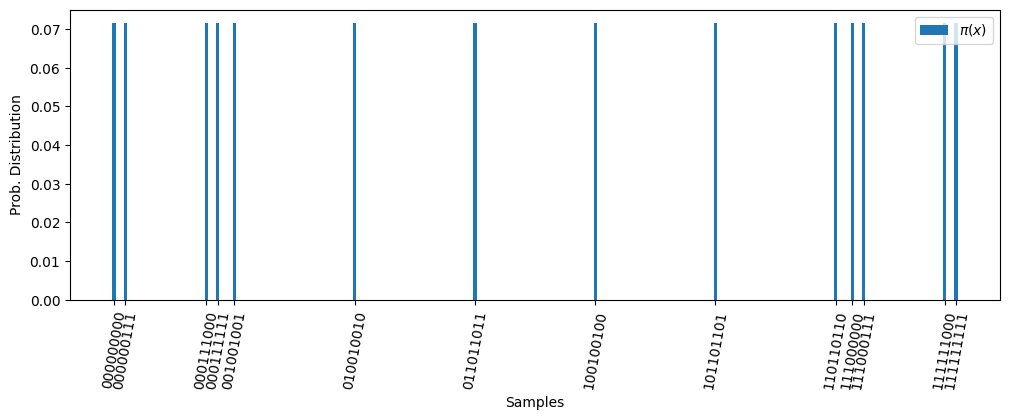

In [8]:
probs = np.zeros(2**size)
probs[nums] = 1 / len(data)

plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**size), probs, width=2.0, label=r"$\pi(x)$")
plt.xticks(nums, bitstrings, rotation=80)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()


In [9]:
import pennylane as qml

np.random.seed(42)


n_qubits = size
dev = qml.device("default.qubit", wires=n_qubits)

n_layers = 6
wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=wshape)


@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(weights=weights, ranges=[1] * n_layers, wires=range(n_qubits))
    return qml.probs()


jit_circuit = jax.jit(circuit)


In [10]:
import optax

bandwidth = jnp.array([0.25, 0.5, 1])
space = jnp.arange(2**n_qubits)

mmd = MMD(bandwidth, space)
qcbm = QCBM(jit_circuit, mmd, probs)

opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(weights)


In [11]:
@jax.jit
def update_step(params, opt_state):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))
    return params, opt_state, loss_val, kl_div

mmd
history = []
divs = []
n_iterations = 100

for i in range(n_iterations):
    weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)


AttributeError: 'QCBM' object has no attribute 'mmd_loss'